batches create dictionaries of metric bundles, which can then be passed to metric bundle groups.

samples in $SIMS_MAF/maf/batches

In [27]:
import rubin_sim
from rubin_sim import maf

In [28]:
import os
import tempfile
import logging
import urllib
import textwrap
import pprint
import tempfile
import warnings
from functools import partial
from collections import OrderedDict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorcet
import pandas as pd
import sqlite3

from IPython.display import Image

## Set the storage directory for this notebook

Set the directory in which to look for metrics already computed.

In [29]:
data_dir = os.path.join('.', 'bulk_metric_data')

In [30]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Looking at results

## Extend the `ResultsDb` class to return `pandas.DataFrame`s.

In [31]:
class ResultsDbDF(maf.ResultsDb):
    def get_metrics_df(self, index_col='metricId'):
        metrics_df = pd.read_sql('SELECT * FROM metrics',
                                 self.session.connection(),
                                 index_col=index_col)
        self.infer_bundle_name(metrics_df, inplace=True)
        metrics_df.sort_index(inplace=True)
        return metrics_df
    
    def get_plots_df(self, index_col='plotId'):
        plots_df = pd.read_sql('SELECT * FROM plots LEFT NATURAL JOIN metrics',
                               self.session.connection(),
                               index_col=index_col)
        plots_df['thumbFile'] = plots_df.plotFile.apply(lambda f: 'thumb.' + '.'.join(f.split('.')[:-1]) + '.png')
        self.infer_bundle_name(plots_df, inplace=True)
        plots_df.sort_index(inplace=True)
        return plots_df
    
    def get_summary_df(self, index_col='statId'):
        summary_df = pd.read_sql('SELECT * FROM summarystats LEFT NATURAL JOIN metrics',
                                 self.session.connection(),
                                 index_col=index_col)
        self.infer_bundle_name(summary_df, inplace=True)
        summary_df.sort_index(inplace=True)
        return summary_df        
    
    def infer_bundle_name(self, df, inplace=False):
        if not inplace:
            df = metrics_df.copy()
            
        df['bundleName'] = df.metricDataFile.apply(
            lambda mdf: '.'.join(mdf.split('.')[:-1]))
            
        return df

Now we can use this to create `DataFrame`s from all results databases in a list of directories:

In [32]:
def get_all_dfs(get_method_name, index_col, data_dirs):
    df_list = []
    
    # Support getting either just one or an iterable
    # of directories
    if isinstance(data_dirs, str):
        data_dirs = [data_dirs]
    
    def add_df(data_dir):
        if os.path.isfile(os.path.join(data_dir, 'resultsDb_sqlite.db')):
            results_db = ResultsDbDF(outDir=data_dir)
            get_func = getattr(results_db, get_method_name)
            df = get_func(index_col=None)
            if len(df)<1:
                return df

            df['outDir'] = data_dir
            df['outDirId'] = len(df_list)+1
            df.set_index(index_col, inplace=True)
            df_list.append(df)
        
    for data_dir in data_dirs:
        for dirpath, dirnames, filenames in os.walk(data_dir):
            add_df(dirpath)
            
    df = pd.concat(df_list)
    return df
        
read_all_metrics_df = partial(get_all_dfs, 'get_metrics_df', ['outDirId', 'metricId'])
read_all_plots_df = partial(get_all_dfs, 'get_plots_df', ['outDirId', 'metricId', 'plotId'])
read_all_summary_df = partial(get_all_dfs, 'get_summary_df', ['outDirId', 'metricId', 'statId'])

In [33]:
read_all_metrics_df(data_dir).head()

metricName     slicerName  \
outDirId metricId                                       
1        1         OpenShutterFraction      UniSlicer   
         2               Count airmass     OneDSlicer   
         3                     CoaddM5  HealpixSlicer   
         4                     CoaddM5  HealpixSlicer   
2        1         OpenShutterFraction      UniSlicer   

                                  simDataName sqlConstraint metricMetadata  \
outDirId metricId                                                            
1        1          baseline_nexp2_v1.7_10yrs                                
         2          baseline_nexp2_v1.7_10yrs                                
         3          baseline_nexp2_v1.7_10yrs  filter = 'i'              i   
         4          baseline_nexp2_v1.7_10yrs  filter = 'g'              g   
2        1         baseline_2snaps_v1.5_10yrs                                

                                                      metricDataFile  \
outDirId metricId                                                      
1        1         baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...   
         2          baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
         3              baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz   
         4              baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz   
2        1         baseline_2snaps_v1_5_10yrs_OpenShutterFraction...   

                                                          bundleName  \
outDirId metricId                                                      
1        1         baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...   
         2              baseline_nexp2_v1_7_10yrs_Count_airmass_ONED   
         3                  baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL   
         4                  baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL   
2        1         baseline_2snaps_v1_5_10yrs_OpenShutterFraction...   

                                                              outDir  
outDirId metricId                                                     
1        1         ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
         2         ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
         3         ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
         4         ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
2        1         ./bulk_metric_data/baseline_2snaps_v1.5_10yrs/...

In [34]:
read_all_plots_df(data_dir).head()

plotType  \
outDirId metricId plotId               
1        2        1       BinnedData   
         3        2           SkyMap   
                  3        Histogram   
         4        4           SkyMap   
                  5        Histogram   

                                                                   plotFile  \
outDirId metricId plotId                                                      
1        2        1       baseline_nexp2_v1_7_10yrs_Count_airmass_ONED_B...   
         3        2       baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_SkyMa...   
                  3       baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_Histo...   
         4        4       baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_SkyMa...   
                  5       baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_Histo...   

                             metricName     slicerName  \
outDirId metricId plotId                                 
1        2        1       Count airmass     OneDSlicer   
         3        2             CoaddM5  HealpixSlicer   
                  3             CoaddM5  HealpixSlicer   
         4        4             CoaddM5  HealpixSlicer   
                  5             CoaddM5  HealpixSlicer   

                                        simDataName sqlConstraint  \
outDirId metricId plotId                                            
1        2        1       baseline_nexp2_v1.7_10yrs                 
         3        2       baseline_nexp2_v1.7_10yrs  filter = 'i'   
                  3       baseline_nexp2_v1.7_10yrs  filter = 'i'   
         4        4       baseline_nexp2_v1.7_10yrs  filter = 'g'   
                  5       baseline_nexp2_v1.7_10yrs  filter = 'g'   

                         metricMetadata  \
outDirId metricId plotId                  
1        2        1                       
         3        2                   i   
                  3                   i   
         4        4                   g   
                  5                   g   

                                                            metricDataFile  \
outDirId metricId plotId                                                     
1        2        1       baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
         3        2           baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz   
                  3           baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz   
         4        4           baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz   
                  5           baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz   

                                                                  thumbFile  \
outDirId metricId plotId                                                      
1        2        1       thumb.baseline_nexp2_v1_7_10yrs_Count_airmass_...   
         3        2       thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL...   
                  3       thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL...   
         4        4       thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL...   
                  5       thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL...   

                                                            bundleName  \
outDirId metricId plotId                                                 
1        2        1       baseline_nexp2_v1_7_10yrs_Count_airmass_ONED   
         3        2           baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL   
                  3           baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL   
         4        4           baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL   
                  5           baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL   

                                                                     outDir  
outDirId metricId plotId                                                     
1        2        1       ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
         3        2       ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
                  3       ./bulk_metric_data/baseline_nexp2_v1.7_10y

In [35]:
read_all_summary_df(data_dir).head()

summaryName   summaryValue           metricName  \
outDirId metricId statId                                                   
1        1        1         Identity       0.708027  OpenShutterFraction   
         2        2             Mean   68183.100000        Count airmass   
                  3              Rms  133240.794104        Count airmass   
                  4           Median    6683.000000        Count airmass   
                  5              Max  544349.000000        Count airmass   

                          slicerName                simDataName sqlConstraint  \
outDirId metricId statId                                                        
1        1        1        UniSlicer  baseline_nexp2_v1.7_10yrs                 
         2        2       OneDSlicer  baseline_nexp2_v1.7_10yrs                 
                  3       OneDSlicer  baseline_nexp2_v1.7_10yrs                 
                  4       OneDSlicer  baseline_nexp2_v1.7_10yrs                 
                  5       OneDSlicer  baseline_nexp2_v1.7_10yrs                 

                         metricMetadata  \
outDirId metricId statId                  
1        1        1                       
         2        2                       
                  3                       
                  4                       
                  5                       

                                                             metricDataFile  \
outDirId metricId statId                                                      
1        1        1       baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...   
         2        2        baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
                  3        baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
                  4        baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
                  5        baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   

                                                                 bundleName  \
outDirId metricId statId                                                      
1        1        1       baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...   
         2        2            baseline_nexp2_v1_7_10yrs_Count_airmass_ONED   
                  3            baseline_nexp2_v1_7_10yrs_Count_airmass_ONED   
                  4            baseline_nexp2_v1_7_10yrs_Count_airmass_ONED   
                  5            baseline_nexp2_v1_7_10yrs_Count_airmass_ONED   

                                                                     outDir  
outDirId metricId statId                                                     
1        1        1       ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
         2        2       ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
                  3       ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
                  4       ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
                  5       ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...

# Looking at the plots you've made already

In [36]:
maf_plots = read_all_plots_df(data_dir)
maf_plots.head()

plotType  \
outDirId metricId plotId               
1        2        1       BinnedData   
         3        2           SkyMap   
                  3        Histogram   
         4        4           SkyMap   
                  5        Histogram   

                                                                   plotFile  \
outDirId metricId plotId                                                      
1        2        1       baseline_nexp2_v1_7_10yrs_Count_airmass_ONED_B...   
         3        2       baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_SkyMa...   
                  3       baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_Histo...   
         4        4       baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_SkyMa...   
                  5       baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_Histo...   

                             metricName     slicerName  \
outDirId metricId plotId                                 
1        2        1       Count airmass     OneDSlicer   
         3        2             CoaddM5  HealpixSlicer   
                  3             CoaddM5  HealpixSlicer   
         4        4             CoaddM5  HealpixSlicer   
                  5             CoaddM5  HealpixSlicer   

                                        simDataName sqlConstraint  \
outDirId metricId plotId                                            
1        2        1       baseline_nexp2_v1.7_10yrs                 
         3        2       baseline_nexp2_v1.7_10yrs  filter = 'i'   
                  3       baseline_nexp2_v1.7_10yrs  filter = 'i'   
         4        4       baseline_nexp2_v1.7_10yrs  filter = 'g'   
                  5       baseline_nexp2_v1.7_10yrs  filter = 'g'   

                         metricMetadata  \
outDirId metricId plotId                  
1        2        1                       
         3        2                   i   
                  3                   i   
         4        4                   g   
                  5                   g   

                                                            metricDataFile  \
outDirId metricId plotId                                                     
1        2        1       baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
         3        2           baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz   
                  3           baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz   
         4        4           baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz   
                  5           baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz   

                                                                  thumbFile  \
outDirId metricId plotId                                                      
1        2        1       thumb.baseline_nexp2_v1_7_10yrs_Count_airmass_...   
         3        2       thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL...   
                  3       thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL...   
         4        4       thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL...   
                  5       thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL...   

                                                            bundleName  \
outDirId metricId plotId                                                 
1        2        1       baseline_nexp2_v1_7_10yrs_Count_airmass_ONED   
         3        2           baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL   
                  3           baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL   
         4        4           baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL   
                  5           baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL   

                                                                     outDir  
outDirId metricId plotId                                                     
1        2        1       ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
         3        2       ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
                  3       ./bulk_metric_data/baseline_nexp2_v1.7_10y

Display `i` band depth sky maps for all runs:

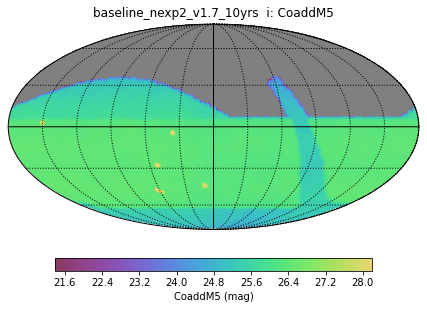

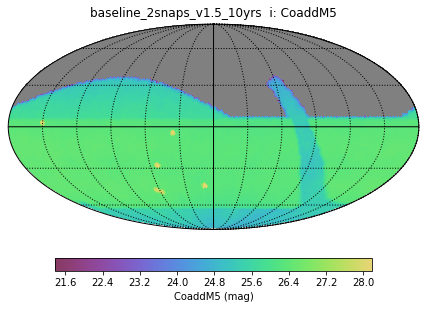

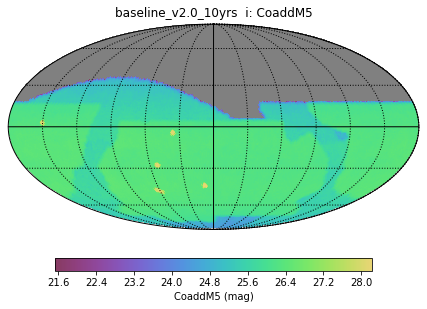

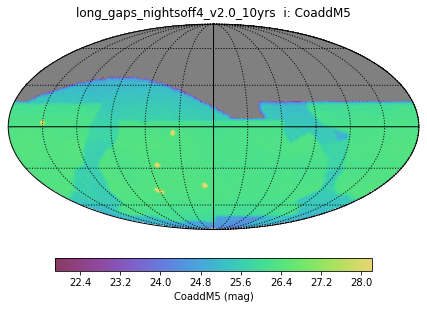

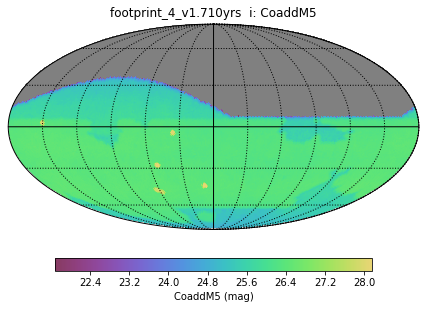

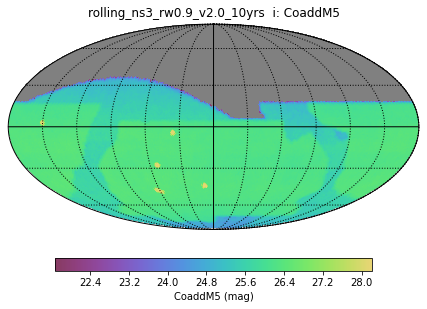

In [37]:
these_maf_plots = maf_plots.query('plotType=="SkyMap" and metricName=="CoaddM5" and metricMetadata==" i"')
for idx, row in these_maf_plots.iterrows():
    display(Image(os.path.join(row.outDir, row.thumbFile)))

# Comparing summary statistics

## Getting summary data

In [38]:
summary_stats = read_all_summary_df(data_dir)
summary_stats

summaryName   summaryValue           metricName  \
outDirId metricId statId                                                   
1        1        1         Identity       0.708027  OpenShutterFraction   
         2        2             Mean   68183.100000        Count airmass   
                  3              Rms  133240.794104        Count airmass   
                  4           Median    6683.000000        Count airmass   
                  5              Max  544349.000000        Count airmass   
...                              ...            ...                  ...   
6        3        13          Median      26.265801              CoaddM5   
                  14             Max      28.221536              CoaddM5   
         4        15             Min      26.636915              CoaddM5   
                  16          Median      26.799028              CoaddM5   
                  17             Max      28.727398              CoaddM5   

                             slicerName                   simDataName  \
outDirId metricId statId                                                
1        1        1           UniSlicer     baseline_nexp2_v1.7_10yrs   
         2        2          OneDSlicer     baseline_nexp2_v1.7_10yrs   
                  3          OneDSlicer     baseline_nexp2_v1.7_10yrs   
                  4          OneDSlicer     baseline_nexp2_v1.7_10yrs   
                  5          OneDSlicer     baseline_nexp2_v1.7_10yrs   
...                                 ...                           ...   
6        3        13      HealpixSlicer  rolling_ns3_rw0.9_v2.0_10yrs   
                  14      HealpixSlicer  rolling_ns3_rw0.9_v2.0_10yrs   
         4        15      HealpixSlicer  rolling_ns3_rw0.9_v2.0_10yrs   
                  16      HealpixSlicer  rolling_ns3_rw0.9_v2.0_10yrs   
                  17      HealpixSlicer  rolling_ns3_rw0.9_v2.0_10yrs   

                         sqlConstraint metricMetadata  \
outDirId metricId statId                                
1        1        1                                     
         2        2                                     
                  3                                     
                  4                                     
                  5                                     
...                                ...            ...   
6        3        13      filter = 'i'              i   
                  14      filter = 'i'              i   
         4        15      filter = 'g'              g   
                  16      filter = 'g'              g   
                  17      filter = 'g'              g   

                                                             metricDataFile  \
outDirId metricId statId                                                      
1        1        1       baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...   
         2        2        baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
                  3        baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
                  4        baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
                  5        baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
...                                                                     ...   
6        3        13        rolling_ns3_rw0_9_v2_0_10yrs_CoaddM5_i_HEAL.npz   
                  14        rolling_ns3_rw0_9_v2_0_10yrs_CoaddM5_i_HEAL.npz   
         4        15        rolling_ns3_rw0_9_v2_0_10yrs_CoaddM5_g_HEAL.npz   
                  16        rolling_ns3_rw0_9_v2_0_10yrs_CoaddM5_g_HEAL.npz   
                  17        rolling_ns3_rw0_9_v2_0_10yrs_CoaddM5_g_HEAL.npz   

                                                                 bundleName  \
outDirId metricId statId                                                      
1        1        1       baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...   
         2        2            baseline_nexp2_v1_7_10yrs_Count_airmass_ONED   


Make a basic plot of a summary statistic with respect to run:

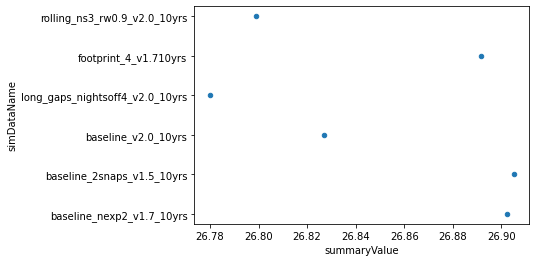

In [ ]:
these_summary_stats = summary_stats.query('metricName=="CoaddM5" and metricMetadata==" g" and slicerName=="HealpixSlicer" and summaryName=="Median"')
ax = these_summary_stats.plot.scatter('summaryValue', 'simDataName')

## Combinations of runs and summary statistics

In [40]:
summary_matrix = summary_stats.pivot_table(index=('metricName', 'metricMetadata', 'summaryName'), values='summaryValue', columns='simDataName')
summary_matrix

simDataName                                     baseline_2snaps_v1.5_10yrs  \
metricName          metricMetadata summaryName                               
CoaddM5              g             Max                           28.668771   
                                   Median                        26.905178   
                                   Min                           26.680652   
                     i             Max                           28.190311   
                                   Median                        26.354405   
                                   Min                           26.130982   
Count airmass                      25th%ile                    2112.500000   
                                   75th%ile                   48478.750000   
                                   Count                         30.000000   
                                   Max                       525350.000000   
                                   Mean                       68564.233333   
                                   Median                      8200.000000   
                                   Min                          188.000000   
                                   N(+3Sigma)                     1.000000   
                                   N(-3Sigma)                     0.000000   
                                   Rms                       128286.896405   
OpenShutterFraction                Identity                       0.715772   

simDataName                                     baseline_nexp2_v1.7_10yrs  \
metricName          metricMetadata summaryName                              
CoaddM5              g             Max                          28.684006   
                                   Median                       26.902416   
                                   Min                          26.707464   
                     i             Max                          28.201292   
                                   Median                       26.357288   
                                   Min                          26.174608   
Count airmass                      25th%ile                   1782.750000   
                                   75th%ile                  40629.250000   
                                   Count                        30.000000   
                                   Max                      544349.000000   
                                   Mean                      68183.100000   
                                   Median                     6683.000000   
                                   Min                         258.000000   
                                   N(+3Sigma)                    1.000000   
                                   N(-3Sigma)                    0.000000   
                                   Rms                      133240.794104   
OpenShutterFraction                Identity                      0.708027   

simDataName                                     baseline_v2.0_10yrs  \
metricName          metricMetadata summaryName                        
CoaddM5              g             Max                    28.716959   
                                   Median                 26.827013   
                                   Min                    26.667973   
                     i             Max                    28.232372   
                                   Median                 26.282296   
                                   Min                    26.095253   
Count airmass                      25th%ile             3377.750000   
                                   75th%ile            98844.750000   
                                   Count                  30.000000   
                                   Max                366284.000000   
                                   Mean                69487.533333   
                                   Median              13465.000000   
                                   Min                   82

/tmp/ipykernel_1826193/2840326470.py:3: RuntimeWarning: invalid value encountered in true_divide
  norm_values = ((summary_matrix.values.T - ref_values)/ref_values).T


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

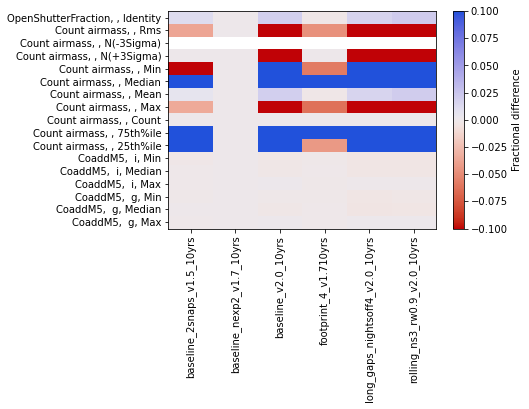

In [41]:
def metric_mesh(summary_matrix, ref_run = 'baseline_nexp2_v1.7_10yrs', vrange=None):
    ref_values = summary_matrix[ref_run].values
    norm_values = ((summary_matrix.values.T - ref_values)/ref_values).T
    
    if vrange is None:
        vrange = 2*max(np.max(norm_values), -1*np.min(norm_values))

    vmin = -1*vrange/2
    vmax = vrange/2
        
    fig, ax = plt.subplots()
    y_nums, x_nums = np.arange(summary_matrix.shape[0]+1), np.arange(summary_matrix.shape[1]+1)
    im = ax.pcolormesh(x_nums, y_nums, norm_values, vmin=vmin, vmax=vmax, cmap=colorcet.cm.coolwarm_r)

    ax.set_yticks(np.arange(0.5, summary_matrix.shape[0]+0.5))
    if isinstance(summary_matrix.index[0], tuple):
        ax.set_yticklabels([', '.join(i) for i in summary_matrix.index])
    else:
        ax.set_yticklabels(summary_matrix.index)

    ax.set_xticks(np.arange(0.5, summary_matrix.shape[1]+0.5))
    ax.set_xticklabels(summary_matrix.columns, rotation='vertical')

    fig.colorbar(im, ax=ax, label="Fractional difference")
    return fig, ax

metric_mesh(summary_matrix)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

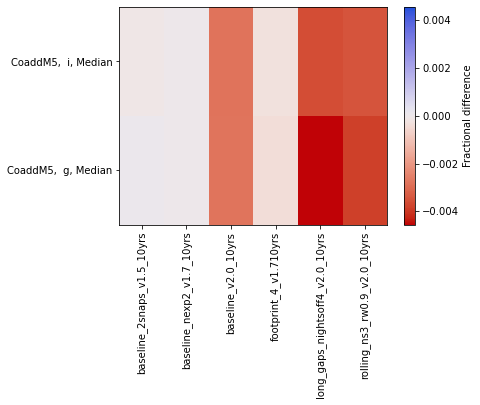

In [42]:
metric_mesh(summary_matrix.loc[(['OpenShutterFraction', 'CoaddM5'], slice(None), 'Median')])

# Reloading metric data

In [43]:
def read_batches(data_dir, opsim_runs=None):
    maf_metrics = read_all_metrics_df(data_dir)
    
    if opsim_runs is None:
        opsim_runs = maf_metrics.simDataName.unique()
    
    batches = {}
    for run_name in opsim_runs:
        batches[run_name] = {}
        batch_metrics = maf_metrics.loc[maf_metrics.simDataName == run_name]
        for bundle_meta_idx, bundle_meta in batch_metrics.iterrows():
            bundle = maf.createEmptyMetricBundle()
            bundle.read(os.path.join(bundle_meta.outDir, bundle_meta.metricDataFile))
            batches[run_name][bundle_meta.bundleName] = bundle

    return batches    

In [44]:
reread_batches = read_batches(data_dir)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


We can now make the plot we made above, but this time using data we releaded from disk:

# Creating new plots

The `batches` provides access to all the data needed to create new plots. Interactively exploring the keys in the nested dictionaries and lists can let a human discover where the data is, but for programatic use it is easier to use the results database to get the necessary metadata:

In [45]:
maf_metrics = read_all_metrics_df(data_dir)
maf_metrics.head()

metricName     slicerName  \
outDirId metricId                                       
1        1         OpenShutterFraction      UniSlicer   
         2               Count airmass     OneDSlicer   
         3                     CoaddM5  HealpixSlicer   
         4                     CoaddM5  HealpixSlicer   
2        1         OpenShutterFraction      UniSlicer   

                                  simDataName sqlConstraint metricMetadata  \
outDirId metricId                                                            
1        1          baseline_nexp2_v1.7_10yrs                                
         2          baseline_nexp2_v1.7_10yrs                                
         3          baseline_nexp2_v1.7_10yrs  filter = 'i'              i   
         4          baseline_nexp2_v1.7_10yrs  filter = 'g'              g   
2        1         baseline_2snaps_v1.5_10yrs                                

                                                      metricDataFile  \
outDirId metricId                                                      
1        1         baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...   
         2          baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz   
         3              baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz   
         4              baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz   
2        1         baseline_2snaps_v1_5_10yrs_OpenShutterFraction...   

                                                          bundleName  \
outDirId metricId                                                      
1        1         baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...   
         2              baseline_nexp2_v1_7_10yrs_Count_airmass_ONED   
         3                  baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL   
         4                  baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL   
2        1         baseline_2snaps_v1_5_10yrs_OpenShutterFraction...   

                                                              outDir  
outDirId metricId                                                     
1        1         ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
         2         ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
         3         ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
         4         ./bulk_metric_data/baseline_nexp2_v1.7_10yrs/b...  
2        1         ./bulk_metric_data/baseline_2snaps_v1.5_10yrs/...

Let's just look at the airmass metric:

In [46]:
airmass_metrics = maf_metrics.query("metricName=='Count airmass'")

We need the run and bundle names to get the bundle out of our dictionary of batches.

Get the run and bundle names for the first one, just as an example:

In [47]:
run_name, bundle_name = airmass_metrics[['simDataName', 'bundleName']].iloc[0]
run_name, bundle_name

('baseline_nexp2_v1.7_10yrs', 'baseline_nexp2_v1_7_10yrs_Count_airmass_ONED')

Now that we have the run and bundle names, we can get the bundle and use it to make a new plot:

{'BinnedData': 1}

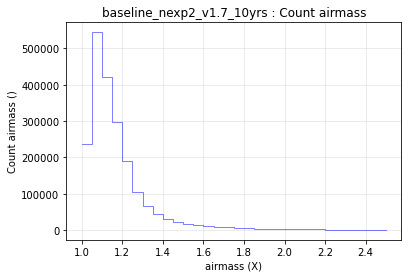

In [48]:
my_metric_bundle = reread_batches[run_name][bundle_name]
my_metric_bundle.plot()

We can overplot all of our airmass bundles this way:

1

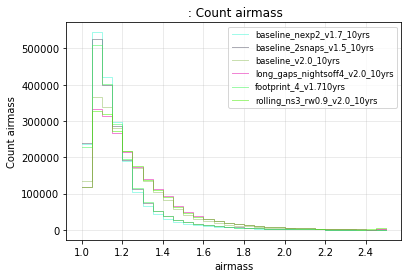

In [49]:
replot_bundles = OrderedDict()
for idx, row in airmass_metrics.iterrows():
    run_name = row.simDataName
    metric_bundle_name = '.'.join(row.metricDataFile.split('.')[:-1])
    replot_bundles[run_name] = reread_batches[run_name][metric_bundle_name]
    
plot_handler = maf.PlotHandler()
plot_handler.setMetricBundles(replot_bundles.values())
plot_dicts = [{'label': k} for k in replot_bundles.keys()]
plot_handler.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plot_dicts)

We can even make mare significant changes, like changing the map projection. In this case, lets use "Eye of Sauron" parameters: force a common color map range to all runs, choose the ['inferno' perceptually uniform colormap](https://bids.github.io/colormap/), and continue to use the Mollweide projection of the sky but rotate it so that the south pole is in the center rather than the bottom, thereby reducing the distortion of the survey footprint

If we want a figure with just one run, it's easiest to use the `setPlotDict` and `setPlotFuncs` methods of our reloaded metric bundle to be what we want:

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


0.0 180.0 -180.0 180.0


{'SkyMap': 1}

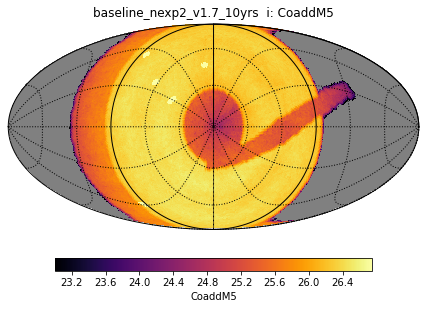

In [50]:
reread_batches = read_batches(data_dir)
depth_map_metrics = maf_metrics.query("slicerName=='HealpixSlicer' and metricName=='CoaddM5' and metricMetadata==' i'")

# Pick just the first, and get the metric bundle from the reread batches
run_name, bundle_name = depth_map_metrics[['simDataName', 'bundleName']].iloc[0]
my_metric_bundle = reread_batches[run_name][bundle_name]
plot_dict = {'rot': (0, -90, 0), 'colorMin': 23, 'colorMax': 26.75, 'cmap': plt.get_cmap('inferno')}
my_metric_bundle.setPlotFuncs([maf.HealpixSkyMap()])
my_metric_bundle.setPlotDict(plot_dict)
my_metric_bundle.plot()

Plotting different runs in subplots of the same figure requires a slightly different approach. Use `maf.PlotHandler`, which can put many plots into the same figure:

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
No handles with labels found to put in legend.


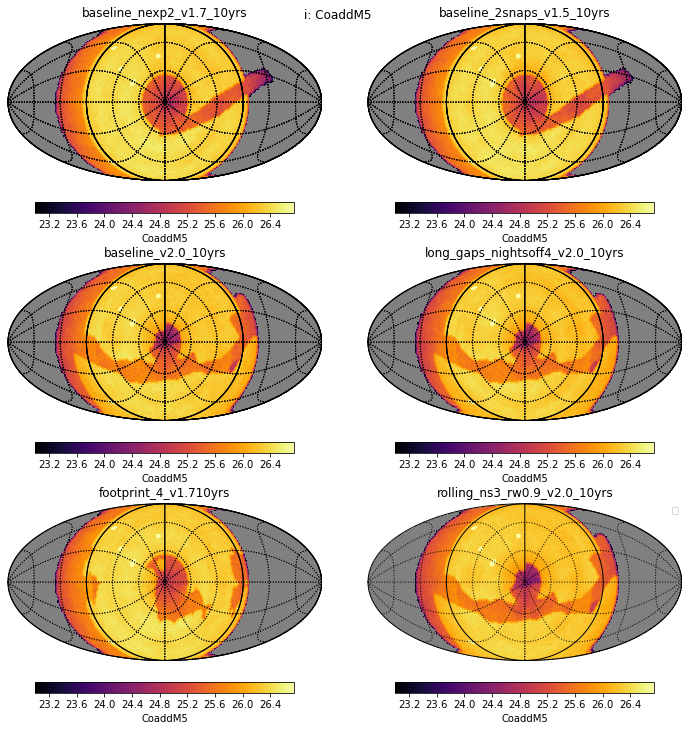

In [51]:
def plot_eyes(data_dir, metric_name, band, plot_ncols=2, figsize=(10, 10)):
    # Reread the batches we saved
    reread_batches = read_batches(data_dir)
    
    maf_metrics = read_all_metrics_df(data_dir)
    maf_metrics_to_plot = maf_metrics.query(f"slicerName=='HealpixSlicer' and metricName=='{metric_name}' and metricMetadata==' {band}'").copy()
    
    # Assign a subplot index to each metric we want to plot
    # and make that the DataFrame index
    # Add 1 because matplotlib subplots start at 1, not 0
    maf_metrics_to_plot['subplot'] = np.arange(len(maf_metrics_to_plot)) + 1
    maf_metrics_to_plot.set_index('subplot', inplace=True)

    # Set up the subplot geometery
    num_plots = len(maf_metrics_to_plot)
    plot_nrows = int(np.ceil(num_plots/plot_ncols))

    # Initialize the lists of bundles and plot_dicts we will
    # be passing to the PlotHandler
    replot_bundles = []
    plot_dicts = []
    
    # Iterate over each plot, adding the bundles and plot_dicts
    # to their respective lists
    for plot_num, row in maf_metrics_to_plot.iterrows():
        run_name = row.simDataName
        bundle_name = row.bundleName
        replot_bundles.append(reread_batches[run_name][bundle_name])
        subplot = 100*plot_nrows + 10*plot_ncols + plot_num
        plot_dicts.append({'label': None,
                           'title': run_name,
                           'rot': (0, -90, 0),
                           'colorMin': 23,
                           'colorMax': 26.75,
                           'cmap': plt.get_cmap('inferno'),
                           'subplot': subplot,
                           'suptitle': f'{band}: {metric_name}',
                           'figsize': figsize})

    # Create the PlotHandler and use it to make the plots
    plot_handler = maf.PlotHandler()
    plot_handler.setMetricBundles(replot_bundles)
    plot_handler.plot(plotFunc=maf.HealpixSkyMap(), plotDicts=plot_dicts)
    
plot_eyes(data_dir, 'CoaddM5', 'i')